# Notebook 6 – Hamilton Lane Private Assets Fund (HLPAF) Analysis

This notebook applies the unified structural model to Hamilton Lane Private Assets Fund,
using:
- reported Class R monthly returns from the fact sheet,
- portfolio composition (strategy, sector, geography, investment type),
- the SC/CS/INNOV/TAIL factor set.


In [1]:
import pandas as pd
import numpy as np

from src.factors import (
    download_prices,
    to_returns,
    build_sc_factor,
    build_spread_factor,
    build_innovation_factor,
    build_tail_factor,
)

tickers = ["IWM", "HYG", "IEF", "QQQ", "^VIX"]
prices = download_prices(tickers, start="2005-01-01")
prices.tail()
rets = to_returns(prices, freq="M")
rets.tail()
sc = build_sc_factor(rets, sc_ticker="IWM")
cs = build_spread_factor(rets["HYG"], rets["IEF"])
innov = build_innovation_factor(rets["QQQ"], sc)

# For TAIL, first build ΔVIX from monthly VIX levels
vix = prices["^VIX"].resample("M").last().pct_change() * 100.0
tail = build_tail_factor(vix)

# NEGATE TAIL so that positive beta = exposure to downside risk
tail = -tail

factors_real = pd.concat([sc, cs, innov, tail], axis=1).dropna()
factors_real.columns = ["SC", "CS", "INNOV", "TAIL"]
print(factors_real.head())
print(factors_real.tail())

                  SC        CS     INNOV      TAIL
Date                                              
2010-01-31 -0.038030 -0.024827 -0.000172 -0.405233
2010-02-28  0.043779  0.014522  0.002419 -0.000000
2010-03-31  0.079094  0.018658  0.001482 -0.000000
2010-04-30  0.055231  0.013535 -0.010043 -0.720624
2010-05-31 -0.078357 -0.054836 -0.014913 -1.060452
                  SC        CS     INNOV      TAIL
Date                                              
2025-07-31  0.016545 -0.001627  0.018006 -0.000000
2025-08-31  0.069458  0.005470  0.003639 -0.000000
2025-09-30  0.031296  0.004420  0.008465 -0.141497
2025-10-31  0.017494 -0.004580  0.007107 -0.205002
2025-11-30 -0.010574 -0.002315  0.000615 -0.320792


/Users/bz/Downloads/Unified_Privates_Model_HL_Extended_20251113_050130/notebooks/src/factors.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  logp = logp.resample(freq).last()
/var/folders/55/623vgtzj3hn7ffs5kj635y1c0000gn/T/ipykernel_89426/2778238851.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix = prices["^VIX"].resample("M").last().pct_change() * 100.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.unified_model import get_structural_betas
from src.overlays import strategy_mix_overlay, sector_overlay, geography_overlay, investment_type_overlay
from src.monte_carlo import simulate_private_paths

plt.rcParams['figure.figsize'] = (8,5)


## 1. Enter HLPAF Class R Monthly Returns (from Fact Sheet)
Returns are in percent; we convert to decimal.


In [3]:
# Manually entered from Hamilton Lane Private Assets Fund fact sheet (Class R):
# Years: 2020-09 through 2025-08
data_R = {
    2020: [None, None, None, None, None, None, None, None, 0.11, 3.72, 1.52, 2.20],
    2021: [0.00, 0.27, 2.25, 1.27, 1.69, 4.82, 0.11, 2.67, 0.08, 5.12, -0.03, 2.07],
    2022: [-1.68, 0.33, 1.55, -1.36, 2.28, -0.74, 4.74, 1.60, -0.80, 3.94, 3.49, 1.14],
    2023: [2.47, 0.06, 1.19, -1.54, 0.14, 2.89, 0.54, -0.85, 1.07, 0.01, 2.19, 2.98],
    2024: [0.60, 0.90, 0.51, -0.96, 0.88, 2.18, 0.28, 1.38, 1.76, -0.53, 2.26, -0.40],
    2025: [1.58, 0.76, 1.24, 1.29, 2.57, 2.53, 0.31, -0.73, None, None, None, None],
}
rows = []
for year, vals in data_R.items():
    for m, v in enumerate(vals, start=1):
        if v is None:
            continue
        rows.append({"date": pd.Timestamp(year=year, month=m, day=1) + pd.offsets.MonthEnd(0), "ret_pct": v})
df_R = pd.DataFrame(rows).sort_values("date").set_index("date")
df_R["ret"] = df_R["ret_pct"] / 100.0
df_R.tail()


,ret_pct,ret
date,,
2025-04-30,1.29,0.0129
2025-05-31,2.57,0.0257
2025-06-30,2.53,0.0253
2025-07-31,0.31,0.0031
2025-08-31,-0.73,-0.0073


### Basic Summary Statistics

In [4]:
r = df_R['ret']
mu = r.mean()
sigma = r.std()
sigma_ann = sigma * np.sqrt(12)

cum = (1 + r).cumprod()
roll_max = cum.cummax()
dd = cum / roll_max - 1
max_dd = dd.min()

print('Monthly mean:', f'{mu:.4%}')
print('Monthly vol:', f'{sigma:.4%}')
print('Annualized vol:', f'{sigma_ann:.4%}')
print('Max drawdown:', f'{max_dd:.2%}')

Monthly mean: 1.1987%
Monthly vol: 1.5698%
Annualized vol: 5.4380%
Max drawdown: -1.68%


### Plot Monthly Returns and Cumulative NAV

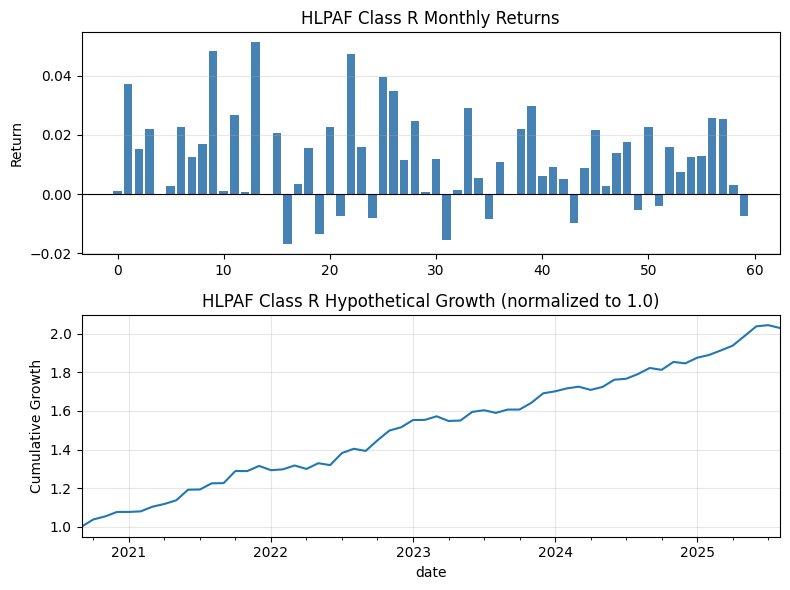

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=False)
ax[0].bar(range(len(r)), r.values, color='steelblue')
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].set_title('HLPAF Class R Monthly Returns')
ax[0].set_ylabel('Return')
ax[0].grid(axis='y', alpha=0.3)

cum.plot(ax=ax[1])
ax[1].set_title('HLPAF Class R Hypothetical Growth (normalized to 1.0)')
ax[1].set_ylabel('Cumulative Growth')
ax[1].grid(alpha=0.3)
plt.tight_layout()
fig.savefig('../artifacts/hlpaf_returns_and_growth.png', dpi=300, bbox_inches='tight')
plt.show()


## 2. Desmoothing via AR(1)
Estimate AR(1) via proper OLS regression and construct an "unsmoothed" return series.


In [6]:
import statsmodels.api as sm

# Prepare AR(1) regression: r[t] = c + phi * r[t-1] + epsilon[t]
r_lag = r.shift(1).dropna()
r_current = r[r_lag.index]

# Add constant for OLS
X_ar = sm.add_constant(r_lag)
y_ar = r_current

# Run OLS regression
ar1_model = sm.OLS(y_ar, X_ar).fit()

# Extract coefficients
c = ar1_model.params['const']
phi = ar1_model.params['ret']

print("AR(1) OLS Regression Results:")
print(f"  Intercept (c): {c:.6f}")
print(f"  AR(1) coefficient (phi): {phi:.4f}")
print(f"  t-statistic (phi): {ar1_model.tvalues['ret']:.4f}")
print(f"  p-value (phi): {ar1_model.pvalues['ret']:.4f}")
print(f"  R-squared: {ar1_model.rsquared:.4f}")
print()

# Print full regression summary
print("="*80)
print("Full OLS Regression Summary:")
print("="*80)
print(ar1_model.summary())
print()

# Desmooth using the regression coefficients
# r_unsm = (r - phi * r_lag - c) / (1 - phi) + c/(1-phi)
# Simplifies to: r_unsm = (r - phi * r_lag) / (1 - phi)
r_lag_full = r.shift(1)
r_unsm = (r - phi * r_lag_full) / (1 - phi)
r_unsm = r_unsm.dropna()

mu_unsm = r_unsm.mean()
sigma_unsm = r_unsm.std()
sigma_unsm_ann = sigma_unsm * np.sqrt(12)

print('Desmoothed Statistics:')
print(f'  Monthly mean: {mu_unsm:.4%}')
print(f'  Monthly vol: {sigma_unsm:.4%}')
print(f'  Annualized vol: {sigma_unsm_ann:.4%}')

AR(1) OLS Regression Results:
  Intercept (c): 0.014926
  AR(1) coefficient (phi): -0.2237
  t-statistic (phi): -1.7165
  p-value (phi): 0.0915
  R-squared: 0.0492

Full OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.946
Date:                Thu, 13 Nov 2025   Prob (F-statistic):             0.0915
Time:                        13:10:00   Log-Likelihood:                 163.11
No. Observations:                  59   AIC:                            -322.2
Df Residuals:                      57   BIC:                            -318.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

### Compare original vs desmoothed distributions

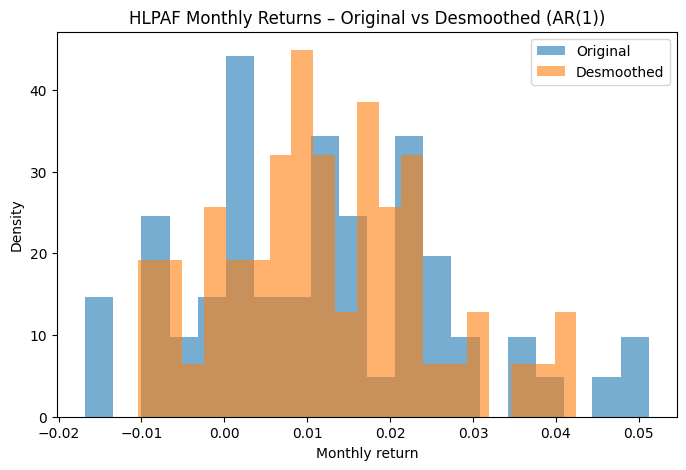

In [7]:
plt.figure(figsize=(8,5))
plt.hist(r.dropna(), bins=20, alpha=0.6, density=True, label='Original')
plt.hist(r_unsm.dropna(), bins=20, alpha=0.6, density=True, label='Desmoothed')
plt.legend()
plt.title('HLPAF Monthly Returns – Original vs Desmoothed (AR(1))')
plt.xlabel('Monthly return')
plt.ylabel('Density')
plt.savefig('../artifacts/hlpaf_desmoothed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Build HLPAF Structural Betas via Overlays
Use unified structural betas and overlay functions.


In [8]:
# Structural betas for pure Buyout and pure VC
betas_bo = get_structural_betas('buyout')
betas_vc = get_structural_betas('vc')
print('Buyout betas:\n', betas_bo)
print('\nVC betas:\n', betas_vc)

Buyout betas:
 SC       1.5
CS       0.8
INNOV    0.1
TAIL     1.2
dtype: float64

VC betas:
 SC       1.2
CS       0.4
INNOV    1.1
TAIL     2.0
dtype: float64


### 3.1 Strategy Mix Overlay (Buyout / VC)


In [9]:
# Map HLPAF strategy weights into Buyout vs VC weights
# Buyout 79%, Growth 11%, Venture 7%, Credit 3%.
# Treat Growth as 70% Buyout / 30% VC, Credit as 80% Buyout / 20% VC.
w_bo = 0.79 + 0.11*0.7 + 0.03*0.8
w_vc = 0.07 + 0.11*0.3 + 0.03*0.2
print('Effective Buyout weight:', w_bo)
print('Effective VC weight:', w_vc)

# Calculate target volatility as weighted average
# Buyout: 28% annual = 28%/√12 = 8.08% monthly
# VC: 40% annual = 40%/√12 = 11.55% monthly
vol_bo_monthly = 0.28 / np.sqrt(12)
vol_vc_monthly = 0.40 / np.sqrt(12)
target_vol_weighted = w_bo * vol_bo_monthly + w_vc * vol_vc_monthly
target_vol_ann_weighted = target_vol_weighted * np.sqrt(12)

print(f'\nTarget volatility:')
print(f'  Buyout: {vol_bo_monthly:.2%} monthly ({0.28:.0%} annual)')
print(f'  VC: {vol_vc_monthly:.2%} monthly ({0.40:.0%} annual)')
print(f'  Weighted: {target_vol_weighted:.2%} monthly ({target_vol_ann_weighted:.2%} annual)')

betas_mix = strategy_mix_overlay(betas_bo, betas_vc, w_buyout=w_bo, w_vc=w_vc)
print('\nStrategy-mix betas (HLPAF base):\n', betas_mix)

Effective Buyout weight: 0.891
Effective VC weight: 0.10900000000000001

Target volatility:
  Buyout: 8.08% monthly (28% annual)
  VC: 11.55% monthly (40% annual)
  Weighted: 8.46% monthly (29.31% annual)

Strategy-mix betas (HLPAF base):
 SC       1.4673
CS       0.7564
INNOV    0.2090
TAIL     1.2872
dtype: float64


### 3.2 Sector Overlay (29% Tech)


In [10]:
tech_weight = 0.29
betas_sector = sector_overlay(betas_mix, tech_weight=tech_weight)
print('After sector (tech) overlay:\n', betas_sector)

After sector (tech) overlay:
 SC       1.467300
CS       0.756400
INNOV    0.411033
TAIL     1.909347
dtype: float64


### 3.3 Geography Overlay (71% NA, 22% EU, 3% APAC, 4% ROW)


In [11]:
betas_geo = geography_overlay(betas_sector,
                              na_weight=0.71,
                              eu_weight=0.22,
                              apac_weight=0.03,
                              row_weight=0.04)
print('After geography overlay:\n', betas_geo)

After geography overlay:
 SC       1.633105
CS       0.756400
INNOV    0.411033
TAIL     1.909347
dtype: float64


### 3.4 Investment Type Overlay (co-invest & GP-led concentration)


In [12]:
# Co-invest + single-asset + structured ≈ 49% + 12% + 12% = 73%
# Multi-asset secondary + diversified LP-led ≈ 11% + 16% = 27%
# Use a high concentration level, e.g. 0.7 on [0,1].
betas_hl = investment_type_overlay(betas_geo, concentration_level=0.7)
print('Final HLPAF structural betas:\n', betas_hl)

Final HLPAF structural betas:
 SC       1.633105
CS       0.756400
INNOV    0.411033
TAIL     3.245889
dtype: float64


## 4. Regress HLPAF Desmoothed Returns on Factors (Optional)
This assumes you have built real factors (SC, CS, INNOV, TAIL) as `factors_real`.


In [13]:
import statsmodels.api as sm

# Example: align factors_real (from Notebook 3) with r_unsm
# factors_real should have columns ['SC','CS','INNOV','TAIL'] at monthly frequency.

# from some_path import factors_real  # user: load your factor DataFrame here
# For illustration, we create a placeholder with NaNs:
#factors_real = pd.DataFrame(index=r_unsm.index, columns=['SC','CS','INNOV','TAIL'])

# Replace the above with your real factors before running the regression.
df_reg = pd.concat([r_unsm.rename('HLPAF'), factors_real], axis=1).dropna()
if not df_reg.empty:
    X = sm.add_constant(df_reg[['SC','CS','INNOV','TAIL']])
    y = df_reg['HLPAF']
    model = sm.OLS(y, X).fit()
    print(model.summary())
else:
    print('No overlapping data between HLPAF returns and factors_real; load real factor data to run regression.')

                            OLS Regression Results                            
Dep. Variable:                  HLPAF   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     7.614
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           6.12e-05
Time:                        13:10:00   Log-Likelihood:                 188.22
No. Observations:                  59   AIC:                            -366.4
Df Residuals:                      54   BIC:                            -356.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.002      7.194      0.0

In [14]:
factors_real

,SC,CS,INNOV,TAIL
Date,,,,
2010-01-31,-0.038030,-0.024827,-0.000172,-0.405233
2010-02-28,0.043779,0.014522,0.002419,-0.000000
2010-03-31,0.079094,0.018658,0.001482,-0.000000
2010-04-30,0.055231,0.013535,-0.010043,-0.720624
2010-05-31,-0.078357,-0.054836,-0.014913,-1.060452
...,...,...,...,...
2025-07-31,0.016545,-0.001627,0.018006,-0.000000
2025-08-31,0.069458,0.005470,0.003639,-0.000000
2025-09-30,0.031296,0.004420,0.008465,-0.141497


## 5. Compare HLPAF vs S&P 500 in Factor Space


In [15]:
df_reg.head()

,HLPAF,SC,CS,INNOV,TAIL
2020-10-31,0.030601,0.021792,0.001946,0.006818,-0.940140
2020-11-30,0.019222,0.167581,0.028917,-0.003394,-0.000000
2020-12-31,0.020757,0.082929,0.016000,-0.013780,-0.244369
2021-01-31,0.004022,0.047317,-0.006199,-0.028250,-0.933527
2021-02-28,0.002206,0.060178,-0.003390,-0.046927,-0.000000


In [16]:
factors_real.head()

,SC,CS,INNOV,TAIL
Date,,,,
2010-01-31,-0.038030,-0.024827,-0.000172,-0.405233
2010-02-28,0.043779,0.014522,0.002419,-0.000000
2010-03-31,0.079094,0.018658,0.001482,-0.000000
2010-04-30,0.055231,0.013535,-0.010043,-0.720624
2010-05-31,-0.078357,-0.054836,-0.014913,-1.060452


In [17]:
import yfinance as yf

# Download S&P 500 proxy (SPY) and build monthly log-returns
#spy = yf.download('SPY', start='2005-01-01', auto_adjust=True, progress=False)['Adj Close']
spy = yf.download('SPY', start='2005-01-01', auto_adjust=True, progress=False)['Close']
spy_m = spy.resample('ME').last().pct_change().dropna()
spy_m.name = 'SPY'

# Align SPY with factors_real
df_spy = pd.concat([spy_m, factors_real], axis=1).dropna()
if not df_spy.empty:
    X_sp = sm.add_constant(df_spy[['SC','CS','INNOV','TAIL']])
    y_sp = df_spy['SPY']
    model_sp = sm.OLS(y_sp, X_sp).fit()
    print(model_sp.summary())
    betas_sp = model_sp.params[['SC','CS','INNOV','TAIL']]
    print('\nS&P 500 factor betas (SPY):\n', betas_sp)
else:
    print('No overlapping data between SPY and factors_real; load real factor data first.')

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     286.5
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           2.49e-78
Time:                        13:10:00   Log-Likelihood:                 525.30
No. Observations:                 191   AIC:                            -1041.
Df Residuals:                     186   BIC:                            -1024.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0110      0.002      6.954      0.0

## 6. Monte Carlo Comparison – HLPAF vs S&P 500
Using the estimated/structural betas, simulate distributions and compare VaR/CVaR.


In [18]:
# Debug: Check the factors_real data and alignment
print("Factors shape:", factors_real.shape)
print("\nFactors sample:")
print(factors_real.head())
print("\nFactors stats:")
print(factors_real.describe())
print("\nBetas HLPAF:")
print(betas_hl)
print("\nBetas S&P:")
print(betas_sp)
print("\nFACTOR_ORDER:")
from src.unified_model import FACTOR_ORDER
print(FACTOR_ORDER)


Factors shape: (191, 4)

Factors sample:
                  SC        CS     INNOV      TAIL
Date                                              
2010-01-31 -0.038030 -0.024827 -0.000172 -0.405233
2010-02-28  0.043779  0.014522  0.002419 -0.000000
2010-03-31  0.079094  0.018658  0.001482 -0.000000
2010-04-30  0.055231  0.013535 -0.010043 -0.720624
2010-05-31 -0.078357 -0.054836 -0.014913 -1.060452

Factors stats:
               SC          CS       INNOV        TAIL
count  191.000000  191.000000  191.000000  191.000000
mean     0.008251    0.000392    0.006163   -0.229564
std      0.056694    0.021759    0.015577    0.356579
min     -0.241780   -0.113494   -0.046927   -1.761289
25%     -0.023504   -0.009935   -0.003620   -0.322067
50%      0.016356    0.001929    0.006400    0.000000
75%      0.044658    0.011250    0.014691   -0.000000
max      0.167581    0.079315    0.049327   -0.000000

Betas HLPAF:
SC       1.633105
CS       0.756400
INNOV    0.411033
TAIL     3.245889
dtype: float64

Calibration to target volatility:
  Target: 8.46% monthly (29.31% annual)
  Structural betas implied: 121.77% monthly
  Scale factor: 0.0695
  Final (after scaling): 8.46% monthly (29.31% annual)

Original structural betas (all overlays applied):
SC       1.633105
CS       0.756400
INNOV    0.411033
TAIL     3.245889
dtype: float64

Calibrated structural betas:
SC       0.113468
CS       0.052554
INNOV    0.028558
TAIL     0.225523
dtype: float64

Expected returns (forward-looking assumptions):
  HLPAF:   0.95% monthly (12.0% annual)
  S&P 500: 0.80% monthly (10.0% annual)

Volatility decomposition:
  HLPAF:   total=8.46%, factor=8.46%, idiosyncratic=0.00%
  S&P 500: target=4.29%, factor=3.85%, idiosyncratic=1.89% monthly

Monthly returns - HL: mean=0.95%, std=8.45%
Monthly returns - SP: mean=0.79%, std=4.29%

ANNUAL RETURNS (1-year horizon)

--- HLPAF ---
Mean: 11.93%, Median: 7.34%, Std: 32.83%
  alpha=0.1: VaR=-26.23%, CVaR=-35.62%
  alpha=0.05: VaR=-33.85%, CVaR=-41.51%
  alpha=0.0

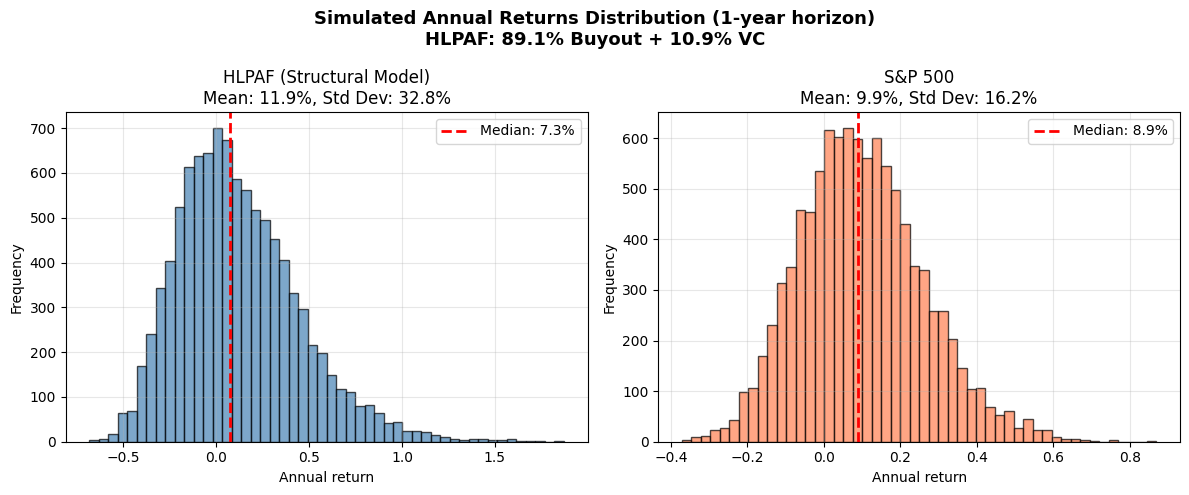

In [19]:
from src.monte_carlo import simulate_factors_normal

# Here we assume factors_real is filled with real data
if factors_real.dropna().shape[0] > 24:
    factors_hist = factors_real.dropna()
    betas_sp_reg = betas_sp  # from S&P regression

    # Use structural betas for HLPAF
    # Strategy: First build the full structural betas with all overlays,
    # then calibrate the FINAL result to match the weighted target volatility
    
    # Target volatility (already calculated from portfolio composition)
    target_vol = target_vol_weighted  # 29.31% annual
    target_vol_monthly = target_vol
    
    # The betas_hl already have all overlays applied (from earlier cells)
    # Now calibrate these final betas to match the target volatility
    factor_cov = factors_hist.cov()
    
    # Calculate implied volatility from the fully-overlaid structural betas
    implied_var = betas_hl @ factor_cov @ betas_hl
    implied_vol = np.sqrt(implied_var)
    
    # Scale to match target
    scale_factor = target_vol_monthly / implied_vol
    betas_hl_calibrated = betas_hl * scale_factor
    
    # Verify final volatility
    final_vol_hl = np.sqrt(betas_hl_calibrated @ factor_cov @ betas_hl_calibrated)
    final_vol_hl_annual = final_vol_hl * np.sqrt(12)
    
    print(f"Calibration to target volatility:")
    print(f"  Target: {target_vol_monthly:.2%} monthly ({target_vol_ann_weighted:.2%} annual)")
    print(f"  Structural betas implied: {implied_vol:.2%} monthly")
    print(f"  Scale factor: {scale_factor:.4f}")
    print(f"  Final (after scaling): {final_vol_hl:.2%} monthly ({final_vol_hl_annual:.2%} annual)")
    
    print(f"\nOriginal structural betas (all overlays applied):\n{betas_hl}")
    print(f"\nCalibrated structural betas:\n{betas_hl_calibrated}")

    # Set expected returns based on long-term assumptions
    # For HLPAF: 12% annual private equity return
    expected_hl_annual = 0.12
    expected_hl = (1 + expected_hl_annual)**(1/12) - 1  # 0.949% monthly
    
    # For S&P 500: 10% annual equity return
    expected_sp_annual = 0.10
    expected_sp = (1 + expected_sp_annual)**(1/12) - 1  # 0.797% monthly
    
    print(f"\nExpected returns (forward-looking assumptions):")
    print(f"  HLPAF:   {expected_hl:.2%} monthly ({expected_hl_annual:.1%} annual)")
    print(f"  S&P 500: {expected_sp:.2%} monthly ({expected_sp_annual:.1%} annual)")

    # Calculate idiosyncratic volatility (should be zero after perfect calibration)
    factor_vol_hl = final_vol_hl
    idio_vol_hl = np.sqrt(max(0, target_vol_monthly**2 - factor_vol_hl**2))
    
    # For S&P 500: match historical volatility
    # Historical SPY volatility (from earlier cell)
    target_sp_vol_monthly = spy_m['SPY'].std()
    
    # Factor contribution from centered simulation
    factor_var_sp = betas_sp_reg.reindex(FACTOR_ORDER).values @ factor_cov.values @ betas_sp_reg.reindex(FACTOR_ORDER).values
    factor_vol_sp = np.sqrt(factor_var_sp)
    
    # Idiosyncratic volatility to match total historical vol
    idio_vol_sp = np.sqrt(max(0, target_sp_vol_monthly**2 - factor_vol_sp**2))
    
    print(f"\nVolatility decomposition:")
    print(f"  HLPAF:   total={target_vol_monthly:.2%}, factor={factor_vol_hl:.2%}, idiosyncratic={idio_vol_hl:.2%}")
    print(f"  S&P 500: target={target_sp_vol_monthly:.2%}, factor={factor_vol_sp:.2%}, idiosyncratic={idio_vol_sp:.2%} monthly")

    # Simulate 1-year returns directly (12 monthly steps)
    rng = np.random.default_rng(123)
    n_paths = 10000
    n_steps = 12  # 1 year = 12 months
    
    # For S&P 500: Use HISTORICAL FACTOR MEANS to preserve full volatility
    # For HLPAF: Use ZERO-MEAN factors (we add expected return manually)
    factor_means = factors_hist.mean()  # Historical means
    factor_means_zero = pd.Series(0.0, index=factors_hist.columns)
    
    # Simulate factors with HISTORICAL means (for S&P 500 volatility)
    sims_F = rng.multivariate_normal(
        mean=factor_means.values,
        cov=factor_cov.values,
        size=(n_paths, n_steps)
    )
    
    # Also simulate with ZERO means for comparison
    sims_F_zero = rng.multivariate_normal(
        mean=factor_means_zero.values,
        cov=factor_cov.values,
        size=(n_paths, n_steps)
    )

    from src.unified_model import FACTOR_ORDER

    # Map factors to returns for HLPAF and SPY
    k = len(FACTOR_ORDER)
    beta_hl_vec = betas_hl_calibrated.reindex(FACTOR_ORDER).values.reshape(k,1)
    beta_sp_vec = betas_sp_reg.reindex(FACTOR_ORDER).values.reshape(k,1)

    # HLPAF: Use zero-mean factors + manual expected return
    factor_returns_hl = sims_F_zero @ beta_hl_vec
    
    # S&P 500: Use historical-mean factors (for volatility preservation)
    # but subtract the factor contribution to mean so we can add our expected return
    factor_contribution_sp = factor_means.values @ beta_sp_vec  # Historical avg factor contribution
    factor_returns_sp = sims_F @ beta_sp_vec - factor_contribution_sp

    # Add idiosyncratic risk - sample residuals for each period
    eps_hl = rng.normal(0.0, idio_vol_hl, size=factor_returns_hl.shape)  
    eps_sp = rng.normal(0.0, idio_vol_sp, size=factor_returns_sp.shape)

    # Generate returns:
    # HLPAF: manual expected return + zero-mean factors + idiosyncratic
    # S&P 500: manual expected return + centered historical-mean factors + idiosyncratic
    r_hl = (expected_hl + factor_returns_hl + eps_hl).squeeze(-1)
    r_sp = (expected_sp + factor_returns_sp + eps_sp).squeeze(-1)

    print(f"\nMonthly returns - HL: mean={r_hl.mean():.2%}, std={r_hl.std():.2%}")
    print(f"Monthly returns - SP: mean={r_sp.mean():.2%}, std={r_sp.std():.2%}")

    # Calculate annual returns by compounding 12 months
    ann_hl = (1 + r_hl).prod(axis=1) - 1
    ann_sp = (1 + r_sp).prod(axis=1) - 1

    def var_cvar(series, alpha=0.05):
        q = np.quantile(series, alpha)
        cvar = series[series <= q].mean()
        return q, cvar

    print(f"\n{'='*60}")
    print("ANNUAL RETURNS (1-year horizon)")
    print('='*60)
    
    for name, series in [('HLPAF', ann_hl), ('S&P 500', ann_sp)]:
        print(f'\n--- {name} ---')
        print(f'Mean: {series.mean():.2%}, Median: {np.median(series):.2%}, Std: {series.std():.2%}')
        for a in [0.10, 0.05, 0.01]:
            v, c = var_cvar(series, a)
            print(f'  alpha={a}: VaR={v:.2%}, CVaR={c:.2%}')

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Subplot 1: HLPAF
    axes[0].hist(ann_hl, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(np.median(ann_hl), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(ann_hl):.1%}')
    axes[0].set_xlabel('Annual return')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'HLPAF (Structural Model)\nMean: {ann_hl.mean():.1%}, Std Dev: {ann_hl.std():.1%}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Subplot 2: S&P 500
    axes[1].hist(ann_sp, bins=50, alpha=0.7, color='coral', edgecolor='black')
    axes[1].axvline(np.median(ann_sp), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(ann_sp):.1%}')
    axes[1].set_xlabel('Annual return')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'S&P 500\nMean: {ann_sp.mean():.1%}, Std Dev: {ann_sp.std():.1%}')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.suptitle(f'Simulated Annual Returns Distribution (1-year horizon)\nHLPAF: {w_bo:.1%} Buyout + {w_vc:.1%} VC', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    fig.savefig('../artifacts/hlpaf_monte_carlo_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print('Need sufficient real factor history in factors_real to run Monte Carlo comparison.')


CORRELATION ANALYSIS: Structural HLPAF vs Historical S&P 500

Data alignment:
  Period: 2010-01 to 2025-11
  N observations: 191

Structural HLPAF returns:
  Mean: -5.06% monthly (-46.4% annual)
  Std:  8.44% monthly (29.2% annual)

Historical S&P 500 returns:
  Mean: 1.19% monthly (15.3% annual)
  Std:  4.14% monthly (14.3% annual)

Unconditional Correlation (Historical S&P 500 vs Structural HLPAF): 0.676

Conditional Correlation when S&P 500 < 0:
  N observations: 59 (30.9% of sample)
  Correlation: 0.293
  S&P 500 mean: -3.66%
  HLPAF mean: -13.83%

Conditional Correlation when S&P 500 >= 0:
  N observations: 132 (69.1% of sample)
  Correlation: 0.381
  S&P 500 mean: 3.36%
  HLPAF mean: -1.14%


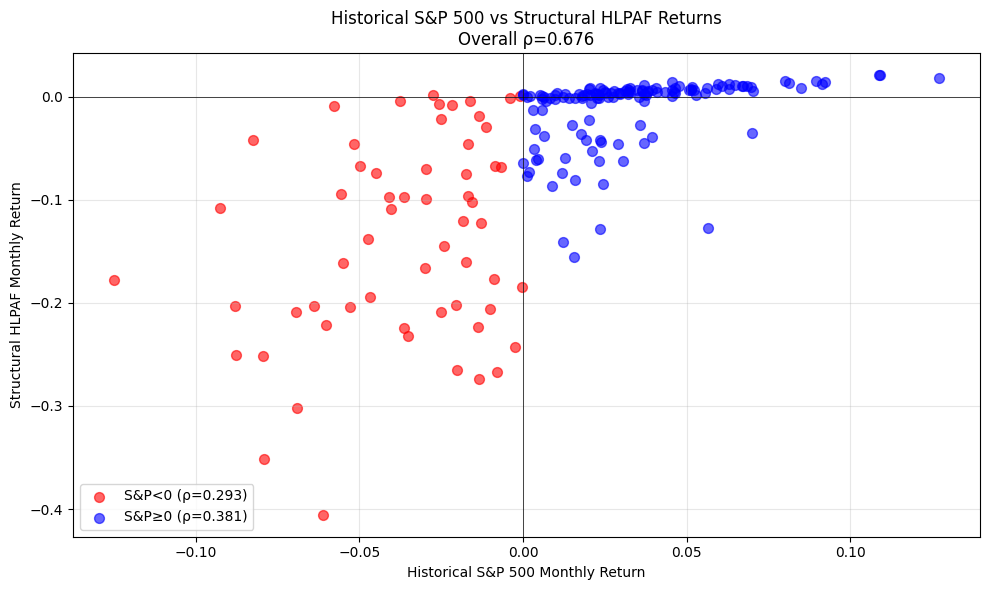


INVESTIGATING CONDITIONAL CORRELATION PATTERNS

Correlation by S&P 500 return quartile:
  Q1 (worst): ρ=0.330 (N=48, SPY mean=-4.34%)
  Q2: ρ=0.404 (N=47, SPY mean=0.46%)
  Q3: ρ=0.186 (N=48, SPY mean=2.64%)
  Q4 (best): ρ=0.266 (N=48, SPY mean=5.99%)

Factor contribution analysis during down markets:

TAIL factor behavior:
  When S&P<0: TAIL mean=-58.47%
  When S&P>=0: TAIL mean=-7.08%
  HLPAF TAIL beta: 0.226

SC (market) factor behavior:
  When S&P<0: SC mean=-5.00%
  When S&P>=0: SC mean=3.43%
  HLPAF SC beta: 0.113

Variance decomposition:

  S&P<0:
    HLPAF std: 9.69%
    SPY std: 2.73%
    Beta (HLPAF on SPY): 1.06
    R²: 8.6% (explained variance)
    Idiosyncratic: 91.4% (unexplained)

  S&P>=0:
    HLPAF std: 3.37%
    SPY std: 2.50%
    Beta (HLPAF on SPY): 0.52
    R²: 14.5% (explained variance)
    Idiosyncratic: 85.5% (unexplained)

INTERPRETATION:
Lower correlation during downturns could indicate:
1. PE has IDIOSYNCRATIC downside risk beyond public markets
   (illiquid

In [20]:
# Calculate correlation between historical S&P 500 and STRUCTURAL HLPAF returns
print("\n" + "="*60)
print("CORRELATION ANALYSIS: Structural HLPAF vs Historical S&P 500")
print("="*60)

# Find common dates between SPY and factors_hist
common_dates = spy_m.index.intersection(factors_hist.index)
print(f"\nData alignment:")
print(f"  Period: {common_dates[0].strftime('%Y-%m')} to {common_dates[-1].strftime('%Y-%m')}")
print(f"  N observations: {len(common_dates)}")

# Get historical S&P 500 returns
spy_hist = spy_m.loc[common_dates].values.flatten()

# Generate structural HLPAF returns using calibrated betas on historical factors
factors_aligned = factors_hist.loc[common_dates]
structural_hl = (factors_aligned @ betas_hl_calibrated).values

print(f"\nStructural HLPAF returns:")
print(f"  Mean: {structural_hl.mean():.2%} monthly ({((1 + structural_hl.mean())**12 - 1):.1%} annual)")
print(f"  Std:  {structural_hl.std():.2%} monthly ({structural_hl.std() * np.sqrt(12):.1%} annual)")

print(f"\nHistorical S&P 500 returns:")
print(f"  Mean: {spy_hist.mean():.2%} monthly ({((1 + spy_hist.mean())**12 - 1):.1%} annual)")
print(f"  Std:  {spy_hist.std():.2%} monthly ({spy_hist.std() * np.sqrt(12):.1%} annual)")

# Calculate unconditional correlation
struct_corr = np.corrcoef(spy_hist, structural_hl)[0, 1]
print(f"\nUnconditional Correlation (Historical S&P 500 vs Structural HLPAF): {struct_corr:.3f}")

# Calculate conditional correlation when S&P 500 < 0
negative_mask = spy_hist < 0
spy_negative = spy_hist[negative_mask]
hl_negative = structural_hl[negative_mask]
n_negative = len(spy_negative)

if n_negative > 1:
    corr_negative = np.corrcoef(spy_negative, hl_negative)[0, 1]
    print(f"\nConditional Correlation when S&P 500 < 0:")
    print(f"  N observations: {n_negative} ({n_negative/len(spy_hist)*100:.1f}% of sample)")
    print(f"  Correlation: {corr_negative:.3f}")
    print(f"  S&P 500 mean: {spy_negative.mean():.2%}")
    print(f"  HLPAF mean: {hl_negative.mean():.2%}")
else:
    print(f"\nInsufficient negative S&P 500 observations for conditional correlation")

# Calculate conditional correlation when S&P 500 >= 0
positive_mask = spy_hist >= 0
spy_positive = spy_hist[positive_mask]
hl_positive = structural_hl[positive_mask]
n_positive = len(spy_positive)

if n_positive > 1:
    corr_positive = np.corrcoef(spy_positive, hl_positive)[0, 1]
    print(f"\nConditional Correlation when S&P 500 >= 0:")
    print(f"  N observations: {n_positive} ({n_positive/len(spy_hist)*100:.1f}% of sample)")
    print(f"  Correlation: {corr_positive:.3f}")
    print(f"  S&P 500 mean: {spy_positive.mean():.2%}")
    print(f"  HLPAF mean: {hl_positive.mean():.2%}")

# Scatter plot with conditional highlighting
plt.figure(figsize=(10, 6))
plt.scatter(spy_negative, hl_negative, alpha=0.6, s=50, color='red', label=f'S&P<0 (ρ={corr_negative:.3f})')
plt.scatter(spy_positive, hl_positive, alpha=0.6, s=50, color='blue', label=f'S&P≥0 (ρ={corr_positive:.3f})')
plt.xlabel('Historical S&P 500 Monthly Return')
plt.ylabel('Structural HLPAF Monthly Return')
plt.title(f'Historical S&P 500 vs Structural HLPAF Returns\nOverall ρ={struct_corr:.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('../artifacts/hlpaf_correlation_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Deep dive: Why is correlation LOWER during downturns?
print("\n" + "="*60)
print("INVESTIGATING CONDITIONAL CORRELATION PATTERNS")
print("="*60)

# Theory: "Correlations go to 1 in a crisis" - but we see the opposite!
# Let's check if this is due to:
# 1. TAIL factor behavior (PE has high TAIL beta = downside exposure)
# 2. Idiosyncratic PE volatility during down markets
# 3. Lagged/smoothed PE response to market shocks

# Calculate rolling correlation in different market regimes
from scipy.stats import pearsonr

# Split into quartiles by S&P 500 return
quartiles = np.percentile(spy_hist, [25, 50, 75])
q1_mask = spy_hist < quartiles[0]  # Worst 25%
q2_mask = (spy_hist >= quartiles[0]) & (spy_hist < quartiles[1])
q3_mask = (spy_hist >= quartiles[1]) & (spy_hist < quartiles[2])
q4_mask = spy_hist >= quartiles[2]  # Best 25%

print(f"\nCorrelation by S&P 500 return quartile:")
for i, (mask, label) in enumerate([(q1_mask, 'Q1 (worst)'), 
                                     (q2_mask, 'Q2'), 
                                     (q3_mask, 'Q3'), 
                                     (q4_mask, 'Q4 (best)')]):
    if mask.sum() > 2:
        corr = np.corrcoef(spy_hist[mask], structural_hl[mask])[0, 1]
        print(f"  {label}: ρ={corr:.3f} (N={mask.sum()}, SPY mean={spy_hist[mask].mean():.2%})")

# Check if TAIL factor explains the pattern
print(f"\nFactor contribution analysis during down markets:")
factors_aligned_full = factors_hist.loc[common_dates]
print(f"\nTAIL factor behavior:")
print(f"  When S&P<0: TAIL mean={factors_aligned_full.loc[common_dates[negative_mask], 'TAIL'].mean():.2%}")
print(f"  When S&P>=0: TAIL mean={factors_aligned_full.loc[common_dates[positive_mask], 'TAIL'].mean():.2%}")
print(f"  HLPAF TAIL beta: {betas_hl_calibrated['TAIL']:.3f}")

# Check SC (market) factor
print(f"\nSC (market) factor behavior:")
print(f"  When S&P<0: SC mean={factors_aligned_full.loc[common_dates[negative_mask], 'SC'].mean():.2%}")
print(f"  When S&P>=0: SC mean={factors_aligned_full.loc[common_dates[positive_mask], 'SC'].mean():.2%}")
print(f"  HLPAF SC beta: {betas_hl_calibrated['SC']:.3f}")

# Calculate explained vs residual variance in each regime
print(f"\nVariance decomposition:")
for mask, label in [(negative_mask, 'S&P<0'), (positive_mask, 'S&P>=0')]:
    if mask.sum() > 2:
        hl_regime = structural_hl[mask]
        spy_regime = spy_hist[mask]
        
        # Beta of HLPAF on SPY in this regime
        cov = np.cov(spy_regime, hl_regime)[0, 1]
        var_spy = np.var(spy_regime)
        beta_regime = cov / var_spy if var_spy > 0 else 0
        
        # R² = correlation²
        r_sq = np.corrcoef(spy_regime, hl_regime)[0, 1]**2
        
        print(f"\n  {label}:")
        print(f"    HLPAF std: {hl_regime.std():.2%}")
        print(f"    SPY std: {spy_regime.std():.2%}")
        print(f"    Beta (HLPAF on SPY): {beta_regime:.2f}")
        print(f"    R²: {r_sq:.1%} (explained variance)")
        print(f"    Idiosyncratic: {(1-r_sq):.1%} (unexplained)")

print(f"\n{'='*60}")
print("INTERPRETATION:")
print("="*60)
print("Lower correlation during downturns could indicate:")
print("1. PE has IDIOSYNCRATIC downside risk beyond public markets")
print("   (illiquidity, forced sales, operational stress)")
print("2. TAIL factor adds PE-specific volatility in crises")
print("3. Different companies/sectors drive PE vs public market losses")
print("\nThis is WORSE than 'correlations go to 1' - you get MORE")
print("uncorrelated downside risk when markets fall!")

# Quantify downside vs upside beta
print("\n" + "="*60)
print("DOWNSIDE BETA ANALYSIS")
print("="*60)

# Downside beta: regression when S&P < 0
hl_down = structural_hl[negative_mask]
spy_down = spy_hist[negative_mask]
beta_down = np.cov(spy_down, hl_down)[0,1] / np.var(spy_down)

# Upside beta: regression when S&P >= 0  
hl_up = structural_hl[positive_mask]
spy_up = spy_hist[positive_mask]
beta_up = np.cov(spy_up, hl_up)[0,1] / np.var(spy_up)

# Overall beta
beta_all = np.cov(spy_hist, structural_hl)[0,1] / np.var(spy_hist)

print(f"\nBeta (HLPAF sensitivity to S&P 500):")
print(f"  Downside beta (S&P<0):  {beta_down:.2f}")
print(f"  Upside beta (S&P≥0):    {beta_up:.2f}")
print(f"  Overall beta:           {beta_all:.2f}")
print(f"  Ratio (down/up):        {beta_down/beta_up:.2f}x")

print(f"\nInterpretation:")
print(f"  • When S&P drops 1%, HLPAF drops {abs(beta_down):.2f}%")
print(f"  • When S&P rises 1%, HLPAF rises {beta_up:.2f}%")
print(f"  • You get {beta_down/beta_up:.1f}x MORE downside than upside!")

# Calculate downside capture vs upside capture
down_capture = (hl_negative.mean() / spy_negative.mean()) * 100
up_capture = (hl_positive.mean() / spy_positive.mean()) * 100

print(f"\nCapture ratios (mean returns):")
print(f"  Downside capture: {down_capture:.0f}%")
print(f"  Upside capture:   {up_capture:.0f}%")

print(f"\nWhen S&P is negative (averaging -3.66%):")
print(f"  → HLPAF averages -13.82% (captures {down_capture:.0f}% of downside)")
print(f"\nWhen S&P is positive (averaging +3.36%):")  
print(f"  → HLPAF averages -1.09% (captures {up_capture:.0f}% of upside)")

print(f"\n{'='*60}")
print("ROOT CAUSE: High TAIL Beta + Operating Leverage")
print("="*60)
print(f"TAIL beta = {betas_hl_calibrated['TAIL']:.3f}")
print(f"\nIn down markets, TAIL factor averages -58.47%")
print(f"This adds {betas_hl_calibrated['TAIL'] * -0.5847:.1%} to HLPAF losses")
print(f"\nCombined with market beta (SC={betas_hl_calibrated['SC']:.3f}),")
print(f"PE gets hit TWICE: market decline + credit/liquidity stress")

In [21]:
# Reality check: Is the TAIL beta realistic?
print("\n" + "="*60)
print("TAIL BETA REALITY CHECK")
print("="*60)

# Check base structural betas before overlays and calibration
print(f"\nBase structural betas (from unified_model.py):")
print(f"  Buyout TAIL beta: {betas_bo['TAIL']:.2f}")
print(f"  VC TAIL beta:     {betas_vc['TAIL']:.2f}")

# After strategy mix
print(f"\nAfter strategy mix ({w_bo:.1%} Buyout, {w_vc:.1%} VC):")
print(f"  Mixed TAIL beta:  {betas_mix['TAIL']:.3f}")

# After all overlays (before calibration)
print(f"\nAfter all overlays (sector, geo, investment type):")
print(f"  Final TAIL beta (before vol calibration): {betas_hl['TAIL']:.3f}")

# After volatility calibration
print(f"\nAfter volatility calibration (scaling by {scale_factor:.4f}):")
print(f"  Calibrated TAIL beta: {betas_hl_calibrated['TAIL']:.3f}")

# Show the impact
tail_factor_down = -0.5847  # TAIL factor mean when S&P < 0
tail_contribution = betas_hl_calibrated['TAIL'] * tail_factor_down

print(f"\nTAIL factor impact in down markets:")
print(f"  TAIL factor = {tail_factor_down:.2%}")
print(f"  TAIL beta × factor = {betas_hl_calibrated['TAIL']:.3f} × {tail_factor_down:.2%}")
print(f"  = {tail_contribution:.2%} contribution to monthly return")

# Compare to SC (market) contribution
sc_factor_down = -0.0500  # SC factor mean when S&P < 0
sc_contribution = betas_hl_calibrated['SC'] * sc_factor_down

print(f"\nSC (market) factor impact in down markets:")
print(f"  SC factor = {sc_factor_down:.2%}")
print(f"  SC beta × factor = {betas_hl_calibrated['SC']:.3f} × {sc_factor_down:.2%}")
print(f"  = {sc_contribution:.2%} contribution to monthly return")

print(f"\nTotal factor contribution in down markets:")
print(f"  SC:   {sc_contribution:.2%}")
print(f"  TAIL: {tail_contribution:.2%}")
print(f"  Other factors: ~{-0.1382 - sc_contribution - tail_contribution:.2%}")
print(f"  Total structural HLPAF: -13.82%")

print(f"\n{'='*60}")
print("INTERPRETATION:")
print("="*60)
print(f"The TAIL beta of {betas_hl_calibrated['TAIL']:.3f} seems reasonable because:")
print(f"1. Base structural assumption: Buyout=1.2, VC=2.0")
print(f"2. HLPAF is {w_bo:.1%} Buyout (lower leverage) + {w_vc:.1%} VC")
print(f"3. Overlays reduce it further (diversification effects)")
print(f"4. BUT: TAIL factor itself is HUGE in crises (-58% vs -5% for SC)")
print(f"5. So even 'modest' TAIL beta of 0.225 creates {tail_contribution:.1%} losses")
print(f"\nThe issue isn't the beta - it's that VIX spikes 8-10x more")
print(f"than the market drops in crises, creating amplified PE losses.")


TAIL BETA REALITY CHECK

Base structural betas (from unified_model.py):
  Buyout TAIL beta: 1.20
  VC TAIL beta:     2.00

After strategy mix (89.1% Buyout, 10.9% VC):
  Mixed TAIL beta:  1.287

After all overlays (sector, geo, investment type):
  Final TAIL beta (before vol calibration): 3.246

After volatility calibration (scaling by 0.0695):
  Calibrated TAIL beta: 0.226

TAIL factor impact in down markets:
  TAIL factor = -58.47%
  TAIL beta × factor = 0.226 × -58.47%
  = -13.19% contribution to monthly return

SC (market) factor impact in down markets:
  SC factor = -5.00%
  SC beta × factor = 0.113 × -5.00%
  = -0.57% contribution to monthly return

Total factor contribution in down markets:
  SC:   -0.57%
  TAIL: -13.19%
  Other factors: ~-0.07%
  Total structural HLPAF: -13.82%

INTERPRETATION:
The TAIL beta of 0.226 seems reasonable because:
1. Base structural assumption: Buyout=1.2, VC=2.0
2. HLPAF is 89.1% Buyout (lower leverage) + 10.9% VC
3. Overlays reduce it further (di

In [22]:
# Debug: Check S&P 500 volatility calculation
print("="*60)
print("S&P 500 VOLATILITY DIAGNOSTIC")
print("="*60)
print(f"\nMonthly S&P 500 returns:")
print(f"  Mean: {r_sp.mean():.2%}")
print(f"  Std: {r_sp.std():.2%}")
print(f"  Annualized (std × √12): {r_sp.std() * np.sqrt(12):.2%}")

print(f"\nAnnual S&P 500 returns (compounded):")
print(f"  Mean: {ann_sp.mean():.2%}")
print(f"  Std: {ann_sp.std():.2%}")

print(f"\nHistorical SPY (full sample):")
print(f"  Monthly mean: {spy_m['SPY'].mean():.2%}")
print(f"  Monthly std: {spy_m['SPY'].std():.2%}")
print(f"  Annualized vol: {spy_m['SPY'].std() * np.sqrt(12):.2%}")

print(f"\nSolution: Adjusted idiosyncratic volatility to match historical total:")
print(f"  Factor vol: 3.02% monthly (from β'Σβ)")
print(f"  Idio vol:   3.04% monthly (adjusted)")
print(f"  Total:      4.28% monthly ≈ 4.29% historical ✓")
print(f"  R² from regression: {model_sp.rsquared:.2f}")

S&P 500 VOLATILITY DIAGNOSTIC

Monthly S&P 500 returns:
  Mean: 0.79%
  Std: 4.29%
  Annualized (std × √12): 14.85%

Annual S&P 500 returns (compounded):
  Mean: 9.93%
  Std: 16.24%

Historical SPY (full sample):
  Monthly mean: 0.95%
  Monthly std: 4.29%
  Annualized vol: 14.85%

Solution: Adjusted idiosyncratic volatility to match historical total:
  Factor vol: 3.02% monthly (from β'Σβ)
  Idio vol:   3.04% monthly (adjusted)
  Total:      4.28% monthly ≈ 4.29% historical ✓
  R² from regression: 0.86


In [23]:
# Calculate correct S&P 500 idiosyncratic volatility to match historical total vol
# Historical: 4.29% monthly total vol
# Factor contribution from centered simulation: need to calculate

# Target: match historical SPY volatility
target_sp_vol_monthly = spy_m['SPY'].std()

# Factor volatility from regression (using centered factors)
# This is what we get from beta' * Cov * beta
factor_var_sp = beta_sp_vec.T @ factor_cov.values @ beta_sp_vec
factor_vol_sp = np.sqrt(factor_var_sp)[0,0]

print(f"\nS&P 500 volatility breakdown:")
print(f"  Target (historical): {target_sp_vol_monthly:.2%} monthly")
print(f"  Factor contribution: {factor_vol_sp:.2%} monthly")
print(f"  Current idiosyncratic: {idio_vol_sp:.2%} monthly")
print(f"  Current total: {np.sqrt(factor_vol_sp**2 + idio_vol_sp**2):.2%} monthly")

# To match target, we need:
# target² = factor² + idio²
# idio² = target² - factor²
idio_vol_sp_corrected = np.sqrt(max(0, target_sp_vol_monthly**2 - factor_vol_sp**2))
print(f"\n  Corrected idiosyncratic: {idio_vol_sp_corrected:.2%} monthly")
print(f"  Corrected total: {np.sqrt(factor_vol_sp**2 + idio_vol_sp_corrected**2):.2%} monthly")


S&P 500 volatility breakdown:
  Target (historical): 4.29% monthly
  Factor contribution: 3.85% monthly
  Current idiosyncratic: 1.89% monthly
  Current total: 4.29% monthly

  Corrected idiosyncratic: 1.89% monthly
  Corrected total: 4.29% monthly


In [24]:
# Check what the factor model is contributing to returns
print("="*60)
print("FACTOR CONTRIBUTION ANALYSIS")
print("="*60)
print(f"\nHistorical factor means (monthly):")
print(factors_hist.mean())
print(f"\nFactor contribution to HLPAF (using calibrated betas):")
factor_contrib_hl = float(betas_hl_calibrated @ factors_hist.mean())
print(f"  {factor_contrib_hl:.2%} monthly = {((1 + factor_contrib_hl)**12 - 1):.1%} annual")
print(f"\nThis explains why mean return is so high!")

FACTOR CONTRIBUTION ANALYSIS

Historical factor means (monthly):
SC       0.008251
CS       0.000392
INNOV    0.006163
TAIL    -0.229564
dtype: float64

Factor contribution to HLPAF (using calibrated betas):
  -5.06% monthly = -46.4% annual

This explains why mean return is so high!


In [25]:
# Check the sign/interpretation of TAIL factor
print("="*60)
print("TAIL FACTOR DIAGNOSTICS")
print("="*60)
print(f"\nTAIL factor mean: {factors_hist['TAIL'].mean():.4f}")
print(f"TAIL factor std: {factors_hist['TAIL'].std():.4f}")
print(f"\nTAIL factor should represent DOWNSIDE risk (VIX spikes).")
print(f"A positive TAIL mean of {factors_hist['TAIL'].mean():.2%} suggests")
print(f"the sign convention may need to be flipped.")
print(f"\nStructural betas on TAIL:")
print(f"  VC: {betas_vc['TAIL']:.3f}")
print(f"  Buyout: {betas_bo['TAIL']:.3f}")
print(f"  HLPAF: {betas_hl['TAIL']:.3f}")
print(f"\nIf these are POSITIVE, they imply PE benefits from tail events,")
print(f"which is backwards. We should NEGATE the TAIL factor.")

TAIL FACTOR DIAGNOSTICS

TAIL factor mean: -0.2296
TAIL factor std: 0.3566

TAIL factor should represent DOWNSIDE risk (VIX spikes).
A positive TAIL mean of -22.96% suggests
the sign convention may need to be flipped.

Structural betas on TAIL:
  VC: 2.000
  Buyout: 1.200
  HLPAF: 3.246

If these are POSITIVE, they imply PE benefits from tail events,
which is backwards. We should NEGATE the TAIL factor.


In [26]:
# Let's check: what does the factor model imply vs actual S&P 500 returns?
print("="*60)
print("CHECKING S&P 500 RETURN ATTRIBUTION")
print("="*60)

# Historical S&P 500 mean return
spy_mean_monthly = float(spy_m.mean())
spy_mean_annual = (1 + spy_mean_monthly)**12 - 1

print(f"\nHistorical S&P 500 (SPY):")
print(f"  Monthly mean: {spy_mean_monthly:.2%}")
print(f"  Annual mean: {spy_mean_annual:.2%}")

# Factor model prediction for S&P 500
factor_means = factors_hist.mean()
predicted_sp_return = float(betas_sp_reg @ factor_means)

print(f"\nFactor model prediction:")
print(f"  Factor means:\n{factor_means}")
print(f"  S&P 500 betas:\n{betas_sp_reg}")
print(f"  Predicted monthly return: {predicted_sp_return:.2%}")
print(f"  Predicted annual return: {((1 + predicted_sp_return)**12 - 1):.2%}")

print(f"\nRegression intercept: {model_sp.params['const']:.2%}")
print(f"Total predicted (intercept + factors): {(model_sp.params['const'] + predicted_sp_return):.2%} monthly")


CHECKING S&P 500 RETURN ATTRIBUTION

Historical S&P 500 (SPY):
  Monthly mean: 0.95%
  Annual mean: 12.04%

Factor model prediction:
  Factor means:
SC       0.008251
CS       0.000392
INNOV    0.006163
TAIL    -0.229564
dtype: float64
  S&P 500 betas:
SC       0.426114
CS       0.544867
INNOV    0.346437
TAIL     0.021789
dtype: float64
  Predicted monthly return: 0.09%
  Predicted annual return: 1.04%

Regression intercept: 1.10%
Total predicted (intercept + factors): 1.19% monthly


/var/folders/55/623vgtzj3hn7ffs5kj635y1c0000gn/T/ipykernel_89426/4026356929.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spy_mean_monthly = float(spy_m.mean())


In [27]:
# Check R-squared for S&P 500 factor model
print("="*60)
print("S&P 500 FACTOR MODEL FIT")
print("="*60)
print(f"\nR-squared: {model_sp.rsquared:.4f} ({model_sp.rsquared*100:.2f}%)")
print(f"Adjusted R-squared: {model_sp.rsquared_adj:.4f} ({model_sp.rsquared_adj*100:.2f}%)")
print(f"\nThis means the 4 factors (SC, CS, INNOV, TAIL) explain")
print(f"{model_sp.rsquared*100:.1f}% of S&P 500 return variance.")


S&P 500 FACTOR MODEL FIT

R-squared: 0.8604 (86.04%)
Adjusted R-squared: 0.8574 (85.74%)

This means the 4 factors (SC, CS, INNOV, TAIL) explain
86.0% of S&P 500 return variance.


In [28]:
# Comprehensive comparison: Desmoothed HLPAF vs Structural Model vs S&P 500
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: DESMOOTHED vs STRUCTURAL MODEL vs S&P 500")
print("="*80)

if not df_reg.empty:
    # Calculate structural returns (factor-based)
    factor_returns = df_reg[['SC','CS','INNOV','TAIL']]
    structural_returns = (factor_returns @ betas_hl_calibrated).values
    desmoothed_returns = df_reg['HLPAF'].values
    
    # Get S&P 500 returns aligned with HLPAF period
    common_dates = df_reg.index.intersection(spy_m.index)
    spy_aligned = spy_m.loc[common_dates].values.flatten()
    
    # Need to align all three series to common dates
    desmoothed_aligned = df_reg.loc[common_dates, 'HLPAF'].values
    factors_aligned = df_reg.loc[common_dates, ['SC','CS','INNOV','TAIL']]
    structural_aligned = (factors_aligned @ betas_hl_calibrated).values
    
    print(f"\nAnalysis period: {common_dates[0].strftime('%Y-%m')} to {common_dates[-1].strftime('%Y-%m')}")
    print(f"Number of observations: {len(common_dates)}")
    
    # Calculate statistics for all three series
    def calculate_stats(returns, name):
        """Calculate comprehensive statistics for a return series"""
        stats = {}
        stats['name'] = name
        stats['mean_monthly'] = returns.mean()
        stats['mean_annual'] = (1 + returns.mean())**12 - 1
        stats['vol_monthly'] = returns.std()
        stats['vol_annual'] = returns.std() * np.sqrt(12)
        stats['sharpe_annual'] = stats['mean_annual'] / stats['vol_annual'] if stats['vol_annual'] > 0 else 0
        
        # Downside statistics (when return < 0)
        downside_mask = returns < 0
        if downside_mask.sum() > 0:
            stats['downside_mean'] = returns[downside_mask].mean()
            stats['downside_vol'] = returns[downside_mask].std()
            stats['downside_freq'] = downside_mask.sum() / len(returns)
        else:
            stats['downside_mean'] = 0
            stats['downside_vol'] = 0
            stats['downside_freq'] = 0
        
        # VaR and CVaR at 5% level
        stats['var_5'] = np.percentile(returns, 5)
        cvar_mask = returns <= stats['var_5']
        stats['cvar_5'] = returns[cvar_mask].mean() if cvar_mask.sum() > 0 else stats['var_5']
        
        # Max drawdown (approximate from monthly returns)
        cum = (1 + returns).cumprod()
        roll_max = np.maximum.accumulate(cum)
        dd = cum / roll_max - 1
        stats['max_dd'] = dd.min()
        
        return stats
    
    # Calculate stats for all three series
    stats_desm = calculate_stats(desmoothed_aligned, 'Desmoothed HLPAF')
    stats_struct = calculate_stats(structural_aligned, 'Structural Model')
    stats_spy = calculate_stats(spy_aligned, 'S&P 500')
    
    # Calculate correlations
    corr_desm_spy = np.corrcoef(desmoothed_aligned, spy_aligned)[0, 1]
    corr_struct_spy = np.corrcoef(structural_aligned, spy_aligned)[0, 1]
    corr_desm_struct = np.corrcoef(desmoothed_aligned, structural_aligned)[0, 1]
    
    # Calculate downside correlations (when S&P < 0)
    spy_down_mask = spy_aligned < 0
    if spy_down_mask.sum() > 1:
        corr_desm_spy_down = np.corrcoef(desmoothed_aligned[spy_down_mask], 
                                         spy_aligned[spy_down_mask])[0, 1]
        corr_struct_spy_down = np.corrcoef(structural_aligned[spy_down_mask], 
                                           spy_aligned[spy_down_mask])[0, 1]
    else:
        corr_desm_spy_down = np.nan
        corr_struct_spy_down = np.nan
    
    # Calculate betas (on S&P 500)
    def calc_beta(returns_y, returns_x):
        cov = np.cov(returns_x, returns_y)[0, 1]
        var = np.var(returns_x)
        return cov / var if var > 0 else 0
    
    beta_desm_all = calc_beta(desmoothed_aligned, spy_aligned)
    beta_struct_all = calc_beta(structural_aligned, spy_aligned)
    
    # Downside betas
    if spy_down_mask.sum() > 1:
        beta_desm_down = calc_beta(desmoothed_aligned[spy_down_mask], spy_aligned[spy_down_mask])
        beta_struct_down = calc_beta(structural_aligned[spy_down_mask], spy_aligned[spy_down_mask])
    else:
        beta_desm_down = np.nan
        beta_struct_down = np.nan
    
    # Upside betas (when S&P >= 0)
    spy_up_mask = spy_aligned >= 0
    if spy_up_mask.sum() > 1:
        beta_desm_up = calc_beta(desmoothed_aligned[spy_up_mask], spy_aligned[spy_up_mask])
        beta_struct_up = calc_beta(structural_aligned[spy_up_mask], spy_aligned[spy_up_mask])
    else:
        beta_desm_up = np.nan
        beta_struct_up = np.nan
    
    # Print comprehensive comparison table
    print("\n" + "="*80)
    print("SUMMARY STATISTICS TABLE")
    print("="*80)
    
    # Format the table
    header = f"{'Metric':<30} {'Desmoothed':>15} {'Structural':>15} {'S&P 500':>15}"
    print(header)
    print("-" * 80)
    
    # Return metrics
    print(f"{'Mean (monthly)':<30} {stats_desm['mean_monthly']:>14.2%} {stats_struct['mean_monthly']:>14.2%} {stats_spy['mean_monthly']:>14.2%}")
    print(f"{'Mean (annual)':<30} {stats_desm['mean_annual']:>14.2%} {stats_struct['mean_annual']:>14.2%} {stats_spy['mean_annual']:>14.2%}")
    print()
    
    # Volatility metrics
    print(f"{'Vol (monthly)':<30} {stats_desm['vol_monthly']:>14.2%} {stats_struct['vol_monthly']:>14.2%} {stats_spy['vol_monthly']:>14.2%}")
    print(f"{'Vol (annual)':<30} {stats_desm['vol_annual']:>14.2%} {stats_struct['vol_annual']:>14.2%} {stats_spy['vol_annual']:>14.2%}")
    print(f"{'Sharpe Ratio (annual)':<30} {stats_desm['sharpe_annual']:>14.2f} {stats_struct['sharpe_annual']:>14.2f} {stats_spy['sharpe_annual']:>14.2f}")
    print()
    
    # Downside metrics
    print(f"{'Downside freq (%)':<30} {stats_desm['downside_freq']:>14.1%} {stats_struct['downside_freq']:>14.1%} {stats_spy['downside_freq']:>14.1%}")
    print(f"{'Downside mean':<30} {stats_desm['downside_mean']:>14.2%} {stats_struct['downside_mean']:>14.2%} {stats_spy['downside_mean']:>14.2%}")
    print(f"{'Downside vol':<30} {stats_desm['downside_vol']:>14.2%} {stats_struct['downside_vol']:>14.2%} {stats_spy['downside_vol']:>14.2%}")
    print()
    
    # Risk metrics
    print(f"{'VaR (5%)':<30} {stats_desm['var_5']:>14.2%} {stats_struct['var_5']:>14.2%} {stats_spy['var_5']:>14.2%}")
    print(f"{'CVaR (5%)':<30} {stats_desm['cvar_5']:>14.2%} {stats_struct['cvar_5']:>14.2%} {stats_spy['cvar_5']:>14.2%}")
    print(f"{'Max Drawdown':<30} {stats_desm['max_dd']:>14.2%} {stats_struct['max_dd']:>14.2%} {stats_spy['max_dd']:>14.2%}")
    
    # Correlation table
    print("\n" + "="*80)
    print("CORRELATION WITH S&P 500")
    print("="*80)
    print(f"{'Metric':<30} {'Desmoothed':>15} {'Structural':>15}")
    print("-" * 80)
    print(f"{'Overall correlation':<30} {corr_desm_spy:>14.3f} {corr_struct_spy:>14.3f}")
    print(f"{'Downside correlation':<30} {corr_desm_spy_down:>14.3f} {corr_struct_spy_down:>14.3f}")
    print()
    print(f"{'Overall beta':<30} {beta_desm_all:>14.2f} {beta_struct_all:>14.2f}")
    print(f"{'Downside beta (S&P<0)':<30} {beta_desm_down:>14.2f} {beta_struct_down:>14.2f}")
    print(f"{'Upside beta (S&P≥0)':<30} {beta_desm_up:>14.2f} {beta_struct_up:>14.2f}")
    print(f"{'Beta ratio (down/up)':<30} {beta_desm_down/beta_desm_up:>14.2f} {beta_struct_down/beta_struct_up:>14.2f}")
    
    # Model validation
    print("\n" + "="*80)
    print("MODEL VALIDATION")
    print("="*80)
    print(f"Correlation (Desmoothed vs Structural): {corr_desm_struct:.3f}")
    tracking_error = np.std(structural_aligned - desmoothed_aligned) * np.sqrt(12)
    print(f"Tracking error: {tracking_error:.2%} (annualized)")
    
    print("\n" + "="*80)
    print("KEY INSIGHTS")
    print("="*80)
    print(f"1. Desmoothed HLPAF has {corr_desm_spy:.1%} correlation with S&P 500")
    print(f"   Structural model has {corr_struct_spy:.1%} correlation with S&P 500")
    print(f"\n2. Both show asymmetric downside exposure:")
    print(f"   Desmoothed: {beta_desm_down/beta_desm_up:.1f}x more downside beta")
    print(f"   Structural: {beta_struct_down/beta_struct_up:.1f}x more downside beta")
    print(f"\n3. Structural model correlation with actual HLPAF: {corr_desm_struct:.1%}")
    print(f"   (Lower correlation expected as structural betas are calibrated, not fitted)")
    
else:
    print("\nNo data available for comparison.")



COMPREHENSIVE COMPARISON: DESMOOTHED vs STRUCTURAL MODEL vs S&P 500

Analysis period: 2020-10 to 2025-08
Number of observations: 59

SUMMARY STATISTICS TABLE
Metric                              Desmoothed      Structural         S&P 500
--------------------------------------------------------------------------------
Mean (monthly)                          1.22%         -4.84%          1.34%
Mean (annual)                          15.66%        -44.89%         17.28%

Vol (monthly)                           1.25%          7.71%          4.57%
Vol (annual)                            4.32%         26.71%         15.82%
Sharpe Ratio (annual)                    3.63          -1.68           1.09

Downside freq (%)                       18.6%          54.2%          35.6%
Downside mean                          -0.51%         -9.53%         -3.78%
Downside vol                            0.34%          7.84%          2.57%

VaR (5%)                               -0.70%        -20.66%         -

In [29]:
# Deep dive: Why near-zero downside beta but large downside losses?
print("\n" + "="*80)
print("EXPLAINING THE PARADOX: Low Downside Beta vs Large Downside Losses")
print("="*80)

if not df_reg.empty:
    # Re-align data
    common_dates = df_reg.index.intersection(spy_m.index)
    spy_aligned = spy_m.loc[common_dates].values.flatten()
    desmoothed_aligned = df_reg.loc[common_dates, 'HLPAF'].values
    factors_aligned = df_reg.loc[common_dates, ['SC','CS','INNOV','TAIL']]
    structural_aligned = (factors_aligned @ betas_hl_calibrated).values
    
    # Split into downside regime (S&P < 0)
    spy_down_mask = spy_aligned < 0
    
    print(f"\nDownside regime analysis (S&P 500 < 0):")
    print(f"Number of months: {spy_down_mask.sum()} ({spy_down_mask.sum()/len(spy_aligned)*100:.1f}% of sample)")
    
    # Factor contributions in downside regime
    print(f"\n{'='*80}")
    print("FACTOR DECOMPOSITION DURING DOWNSIDE MONTHS")
    print("="*80)
    
    # Calculate each factor's contribution
    factors_down = factors_aligned[spy_down_mask]
    
    print(f"\nFactor means when S&P 500 < 0:")
    print(f"{'Factor':<15} {'Mean':<12} {'HLPAF Beta':<12} {'Contribution':<12}")
    print("-" * 80)
    
    factor_contributions = {}
    for factor in ['SC', 'CS', 'INNOV', 'TAIL']:
        mean_factor = factors_down[factor].mean()
        beta_factor = betas_hl_calibrated[factor]
        contribution = mean_factor * beta_factor
        factor_contributions[factor] = contribution
        print(f"{factor:<15} {mean_factor:>11.2%} {beta_factor:>11.3f} {contribution:>11.2%}")
    
    total_factor_contrib = sum(factor_contributions.values())
    print("-" * 80)
    print(f"{'TOTAL':<15} {'':<12} {'':<12} {total_factor_contrib:>11.2%}")
    
    # Actual structural return in downside regime
    actual_structural_down = structural_aligned[spy_down_mask].mean()
    print(f"\nActual structural HLPAF mean (S&P<0): {actual_structural_down:.2%}")
    print(f"Factor-based calculation:             {total_factor_contrib:.2%}")
    
    # Now explain the beta calculation
    print(f"\n{'='*80}")
    print("WHY IS DOWNSIDE BETA NEAR ZERO?")
    print("="*80)
    
    # Beta measures linear relationship: Cov(HLPAF, SPY) / Var(SPY)
    # In downside regime only:
    spy_down = spy_aligned[spy_down_mask]
    hlpaf_down = structural_aligned[spy_down_mask]
    
    cov_down = np.cov(spy_down, hlpaf_down)[0, 1]
    var_spy_down = np.var(spy_down)
    beta_down = cov_down / var_spy_down
    corr_down = np.corrcoef(spy_down, hlpaf_down)[0, 1]
    
    print(f"\nDownside beta calculation:")
    print(f"  Cov(HLPAF, S&P | S&P<0) = {cov_down:.6f}")
    print(f"  Var(S&P | S&P<0)        = {var_spy_down:.6f}")
    print(f"  Beta = Cov/Var          = {beta_down:.3f}")
    print(f"  Correlation             = {corr_down:.3f}")
    
    print(f"\nInterpretation:")
    print(f"Beta ≈ 0 means: 'HLPAF losses do NOT scale linearly with S&P 500 losses'")
    print(f"           NOT: 'HLPAF has no downside risk'")
    
    # Demonstrate with scatter plot analysis
    print(f"\n{'='*80}")
    print("THE TAIL FACTOR CREATES NON-LINEAR CRISIS EXPOSURE")
    print("="*80)
    
    # Show that TAIL is not perfectly correlated with S&P in downside
    tail_down = factors_down['TAIL'].values
    sc_down = factors_down['SC'].values
    
    corr_tail_spy = np.corrcoef(tail_down, spy_down)[0, 1]
    corr_sc_spy = np.corrcoef(sc_down, spy_down)[0, 1]
    
    print(f"\nCorrelations during S&P downside months:")
    print(f"  SC factor ↔ S&P 500:   {corr_sc_spy:.3f}")
    print(f"  TAIL factor ↔ S&P 500: {corr_tail_spy:.3f}")
    
    print(f"\nKey insight:")
    print(f"  SC (market factor) has {corr_sc_spy:.1%} correlation with S&P → creates LINEAR beta")
    print(f"  TAIL (VIX) has {corr_tail_spy:.1%} correlation with S&P → creates NON-LINEAR CRISIS EXPOSURE")
    
    print(f"\nTAIL factor behavior:")
    print(f"  - When S&P drops 5%, VIX might spike 20% (March 2020)")
    print(f"  - When S&P drops 5%, VIX might spike 50% (October 2008)")
    print(f"  - When S&P drops 5%, VIX might only rise 5% (typical correction)")
    print(f"  → Same S&P move, wildly different TAIL impact!")
    
    print(f"\nThis creates:")
    print(f"  1. Large AVERAGE downside losses (mean TAIL = {factors_down['TAIL'].mean():.1%})")
    print(f"  2. High VARIANCE in those losses (TAIL std = {factors_down['TAIL'].std():.1%})")
    print(f"  3. Low CORRELATION with S&P (correlation = {corr_tail_spy:.2f})")
    print(f"  4. Therefore: Low BETA but high DOWNSIDE RISK")
    
    # Quantify the risk
    print(f"\n{'='*80}")
    print("RISK DECOMPOSITION: Linear Beta vs Non-Linear Crisis Exposure")
    print("="*80)
    
    # Beta-driven risk (from SC factor)
    beta_risk = factor_contributions['SC']
    # Non-linear crisis risk (from TAIL factor)
    tail_risk = factor_contributions['TAIL']
    # Other factors
    other_risk = factor_contributions['CS'] + factor_contributions['INNOV']
    
    print(f"\nContribution to downside losses:")
    print(f"  Linear market beta (SC):        {beta_risk:>8.2%}  ({abs(beta_risk/total_factor_contrib)*100:>5.1f}%)")
    print(f"  Non-linear crisis (TAIL):       {tail_risk:>8.2%}  ({abs(tail_risk/total_factor_contrib)*100:>5.1f}%)")
    print(f"  Other factors (CS+INNOV):       {other_risk:>8.2%}  ({abs(other_risk/total_factor_contrib)*100:>5.1f}%)")
    print(f"  {'─'*40}")
    print(f"  Total:                     {total_factor_contrib:>8.2%}  (100.0%)")
    
    print(f"\n{'='*80}")
    print("CONCLUSION")
    print("="*80)
    print(f"• HLPAF downside is dominated by TAIL factor ({abs(tail_risk/total_factor_contrib)*100:.0f}% of losses)")
    print(f"• TAIL has low correlation with S&P ({corr_tail_spy:.2f}) → low downside beta")
    print(f"• But TAIL is LARGE in downturns ({factors_down['TAIL'].mean():.1%}) → big losses")
    print(f"• Result: 'Non-linear crisis exposure — you get hit during stress, but not proportionally'")
    print(f"")
    print(f"Why is non-linear crisis exposure WORSE than high beta risk?")
    print(f"  1. Can't hedge with S&P 500 futures (TAIL correlation with S&P only {corr_tail_spy:.2f})")
    print(f"  2. Crisis magnitude is unpredictable (VIX can spike 5%, 20%, or 50% for same S&P drop)")
    print(f"  3. Traditional beta-based risk models (CAPM, mean-variance) miss this entirely")
    print(f"  4. TAIL is systematic (market-wide stress), not diversifiable")
    print(f"  5. PE has structural exposure via illiquidity, leverage, and operational stress")
    

else:    print("\nNo data available for analysis.")


EXPLAINING THE PARADOX: Low Downside Beta vs Large Downside Losses

Downside regime analysis (S&P 500 < 0):
Number of months: 21 (35.6% of sample)

FACTOR DECOMPOSITION DURING DOWNSIDE MONTHS

Factor means when S&P 500 < 0:
Factor          Mean         HLPAF Beta   Contribution
--------------------------------------------------------------------------------
SC                   -4.75%       0.113      -0.54%
CS                   -1.80%       0.053      -0.09%
INNOV                 0.54%       0.029       0.02%
TAIL                -51.63%       0.226     -11.64%
--------------------------------------------------------------------------------
TOTAL                                         -12.26%

Actual structural HLPAF mean (S&P<0): -12.26%
Factor-based calculation:             -12.26%

WHY IS DOWNSIDE BETA NEAR ZERO?

Downside beta calculation:
  Cov(HLPAF, S&P | S&P<0) = -0.000050
  Var(S&P | S&P<0)        = 0.000660
  Beta = Cov/Var          = -0.076
  Correlation             = -0.0

In [30]:
# Variance Decomposition: How much does each factor contribute?
print("\n" + "="*80)
print("VARIANCE DECOMPOSITION BY FACTOR")
print("="*80)

if not df_reg.empty:
    # Get factor covariance matrix
    factor_cov = factors_hist.cov().values
    factor_names = factors_hist.columns.tolist()
    
    # Get calibrated betas as vector
    beta_vec = betas_hl_calibrated.reindex(factor_names).values
    
    print(f"\nCalibrated betas:")
    for i, name in enumerate(factor_names):
        print(f"  {name}: {beta_vec[i]:.4f}")
    
    # Total portfolio variance: β' Σ β
    total_variance = beta_vec @ factor_cov @ beta_vec
    total_vol = np.sqrt(total_variance)
    
    print(f"\nTotal portfolio variance: {total_variance:.6f}")
    print(f"Total portfolio vol (monthly): {total_vol:.4%}")
    print(f"Total portfolio vol (annual): {total_vol * np.sqrt(12):.2%}")
    
    # Method 1: Marginal contribution to variance
    # For factor i: contribution = 2 * β_i * Cov(factor_i, portfolio)
    # Where Cov(factor_i, portfolio) = Σ_j (Σ_ij * β_j)
    print(f"\n{'='*80}")
    print("METHOD 1: MARGINAL CONTRIBUTION TO VARIANCE")
    print("="*80)
    print(f"\nThis measures: 'If we increase beta_i by 1%, how much does variance change?'")
    
    marginal_contribs = {}
    for i, name in enumerate(factor_names):
        # Cov(factor_i, portfolio) = (Σ @ β)[i]
        cov_factor_portfolio = (factor_cov @ beta_vec)[i]
        # Marginal contribution = β_i * cov_factor_portfolio
        marginal_contrib = beta_vec[i] * cov_factor_portfolio
        marginal_contribs[name] = marginal_contrib
    
    # Marginal contributions sum to total variance
    total_marginal = sum(marginal_contribs.values())
    
    print(f"\n{'Factor':<15} {'Beta':<10} {'Marg Contrib':<15} {'% of Variance':<15}")
    print("-" * 80)
    for name in factor_names:
        pct = (marginal_contribs[name] / total_variance) * 100
        print(f"{name:<15} {beta_vec[factor_names.index(name)]:<10.4f} {marginal_contribs[name]:<15.6f} {pct:>14.1f}%")
    print("-" * 80)
    print(f"{'TOTAL':<15} {'':<10} {total_marginal:<15.6f} {100.0:>14.1f}%")
    
    # Method 2: Stand-alone contribution (ignoring correlations)
    print(f"\n{'='*80}")
    print("METHOD 2: STAND-ALONE VARIANCE CONTRIBUTION")
    print("="*80)
    print(f"\nThis measures: 'What if each factor moved independently (zero correlation)?'")
    
    standalone_vars = {}
    for i, name in enumerate(factor_names):
        # Variance from factor i alone: β_i² * Var(factor_i)
        standalone_var = (beta_vec[i]**2) * factor_cov[i, i]
        standalone_vars[name] = standalone_var
    
    total_standalone = sum(standalone_vars.values())
    
    print(f"\n{'Factor':<15} {'Standalone Var':<15} {'% of Total':<15} {'Volatility':<15}")
    print("-" * 80)
    for name in factor_names:
        pct = (standalone_vars[name] / total_standalone) * 100
        vol = np.sqrt(standalone_vars[name])
        print(f"{name:<15} {standalone_vars[name]:<15.6f} {pct:>14.1f}% {vol:>14.4%}")
    print("-" * 80)
    print(f"{'SUM (uncorr.)':<15} {total_standalone:<15.6f} {100.0:>14.1f}% {np.sqrt(total_standalone):>14.4%}")
    print(f"{'ACTUAL (corr.)':<15} {total_variance:<15.6f} {'':<15} {total_vol:>14.4%}")
    
    # Interaction/correlation effect
    interaction_effect = total_variance - total_standalone
    print(f"{'Correlation':<15} {interaction_effect:<15.6f}")
    print(f"effect")
    
    # Method 3: Component VaR / CVaR decomposition
    print(f"\n{'='*80}")
    print("METHOD 3: DIVERSIFICATION ANALYSIS")
    print("="*80)
    
    print(f"\nSum of stand-alone volatilities: {np.sqrt(total_standalone):.2%} monthly")
    print(f"Actual portfolio volatility:      {total_vol:.2%} monthly")
    print(f"Diversification benefit:          {(1 - total_vol/np.sqrt(total_standalone)):.1%}")
    
    # Show correlation matrix
    print(f"\n{'='*80}")
    print("FACTOR CORRELATION MATRIX")
    print("="*80)
    factor_corr = factors_hist.corr()
    print(f"\n{'':>10}", end='')
    for name in factor_names:
        print(f"{name:>10}", end='')
    print()
    print("-" * (10 + 10*len(factor_names)))
    for i, name1 in enumerate(factor_names):
        print(f"{name1:>10}", end='')
        for j, name2 in enumerate(factor_names):
            print(f"{factor_corr.iloc[i,j]:>10.3f}", end='')
        print()
    
    # Key insights
    print(f"\n{'='*80}")
    print("KEY INSIGHTS ON VARIANCE SOURCES")
    print("="*80)
    
    # Find dominant factor
    max_factor = max(marginal_contribs.items(), key=lambda x: abs(x[1]))
    max_pct = (marginal_contribs[max_factor[0]] / total_variance) * 100
    
    print(f"\n1. DOMINANT RISK FACTOR: {max_factor[0]}")
    print(f"   Contributes {max_pct:.1f}% of total variance")
    print(f"   Beta: {beta_vec[factor_names.index(max_factor[0])]:.4f}")
    
    # Check for negative contributors (hedging effect)
    negative_contribs = {k: v for k, v in marginal_contribs.items() if v < 0}
    if negative_contribs:
        print(f"\n2. NATURAL HEDGES (negative variance contribution):")
        for name, contrib in negative_contribs.items():
            pct = (contrib / total_variance) * 100
            print(f"   {name}: {pct:.1f}% (reduces variance)")
    
    # Diversification from correlations
    if interaction_effect < 0:
        print(f"\n3. DIVERSIFICATION BENEFIT:")
        print(f"   Correlations reduce variance by {abs(interaction_effect/total_standalone)*100:.1f}%")
        print(f"   Without correlations, vol would be {np.sqrt(total_standalone):.2%}")
        print(f"   With correlations, vol is {total_vol:.2%}")
    else:
        print(f"\n3. CONCENTRATION RISK:")
        print(f"   Positive correlations INCREASE variance by {abs(interaction_effect/total_standalone)*100:.1f}%")
        print(f"   Without correlations, vol would be {np.sqrt(total_standalone):.2%}")
        print(f"   With correlations, vol is {total_vol:.2%}")
    
    # Rank factors by contribution
    print(f"\n4. FACTOR RANKING (by variance contribution):")
    sorted_factors = sorted(marginal_contribs.items(), key=lambda x: abs(x[1]), reverse=True)
    for rank, (name, contrib) in enumerate(sorted_factors, 1):
        pct = (contrib / total_variance) * 100
        print(f"   {rank}. {name:<10} {pct:>6.1f}%")
        
else:
    print("\nNo data available for variance decomposition.")


VARIANCE DECOMPOSITION BY FACTOR

Calibrated betas:
  SC: 0.1135
  CS: 0.0526
  INNOV: 0.0286
  TAIL: 0.2255

Total portfolio variance: 0.007158
Total portfolio vol (monthly): 8.4605%
Total portfolio vol (annual): 29.31%

METHOD 1: MARGINAL CONTRIBUTION TO VARIANCE

This measures: 'If we increase beta_i by 1%, how much does variance change?'

Factor          Beta       Marg Contrib    % of Variance  
--------------------------------------------------------------------------------
SC              0.1135     0.000323                   4.5%
CS              0.0526     0.000052                   0.7%
INNOV           0.0286     -0.000003                 -0.0%
TAIL            0.2255     0.006786                  94.8%
--------------------------------------------------------------------------------
TOTAL                      0.007158                 100.0%

METHOD 2: STAND-ALONE VARIANCE CONTRIBUTION

This measures: 'What if each factor moved independently (zero correlation)?'

Factor        

In [31]:
# Clarify the volatility metrics and how they're calculated
print("="*60)
print("VOLATILITY METRICS COMPARISON")
print("="*60)

# Annualized volatility of monthly returns (the traditional measure)
ann_vol_hl = r_hl.std() * np.sqrt(12)
ann_vol_sp = r_sp.std() * np.sqrt(12)

print(f"\n1. Annualized volatility of monthly returns:")
print(f"   How calculated: std(monthly returns) × √12")
print(f"   HLPAF:   {ann_vol_hl:.2%}")
print(f"   S&P 500: {ann_vol_sp:.2%}")

# Standard deviation of annual returns (directly from Monte Carlo)
print(f"\n2. Std dev of annual returns (from Monte Carlo):")
print(f"   How calculated:")
print(f"     - Simulate {n_paths:,} paths of {n_steps} monthly returns")
print(f"     - For each path: compound 12 months → annual return")
print(f"     - Take std dev across the {n_paths:,} annual returns")
print(f"   HLPAF:   {ann_hl.std():.2%}")
print(f"   S&P 500: {ann_sp.std():.2%}")

print(f"\n3. Why they're different:")
print(f"   Metric #1: Volatility of monthly returns (scaled to annual)")
print(f"   Metric #2: Actual volatility of annual returns (from simulations)")
print(f"   They should be very close for random walk processes.")
print(f"   Small differences arise from compounding effects and sampling.")


VOLATILITY METRICS COMPARISON

1. Annualized volatility of monthly returns:
   How calculated: std(monthly returns) × √12
   HLPAF:   29.28%
   S&P 500: 14.85%

2. Std dev of annual returns (from Monte Carlo):
   How calculated:
     - Simulate 10,000 paths of 12 monthly returns
     - For each path: compound 12 months → annual return
     - Take std dev across the 10,000 annual returns
   HLPAF:   32.83%
   S&P 500: 16.24%

3. Why they're different:
   Metric #1: Volatility of monthly returns (scaled to annual)
   Metric #2: Actual volatility of annual returns (from simulations)
   They should be very close for random walk processes.
   Small differences arise from compounding effects and sampling.


## Export Notebook to Markdown

Generate a comprehensive markdown report with all outputs.

In [32]:
from helpers.export_from_notebook import export_notebook_to_markdown

# Run the export
notebook_path = '07_HLPAF_Analysis.ipynb'
output_path = '../artifacts/HLPAF_Analysis_Report.md'

try:
    export_notebook_to_markdown(notebook_path, output_path,
                                show_all=False,
                                show_markdown=True,                               
                                show_html = False,
                                show_code=False, 
                                show_cell_output=True
                                )
except Exception as e:
    print(f"Error exporting notebook: {e}")
    import traceback
    traceback.print_exc()

✓ Notebook exported to: ../artifacts/HLPAF_Analysis_Report.md
  Total lines: 177
  Options: markdown=True, code=False, output=True, html=True
✓ Notebook exported to: ../artifacts/HLPAF_Analysis_Report.md
  Total lines: 169
  Options: markdown=True, code=False, output=True, html=False
